# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.io import loadmat

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. 
# The data is about 53MB so this cell should take a while the first time your run it.
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of 
# data points and apply this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [4]:
print(train_data.shape)
print(test_data.shape)
print(dev_data.shape)
print(mini_train_data.shape)
print(np.unique(Y))
%matplotlib inline

(60000, 784)
(9000, 784)
(1000, 784)
(1000, 784)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

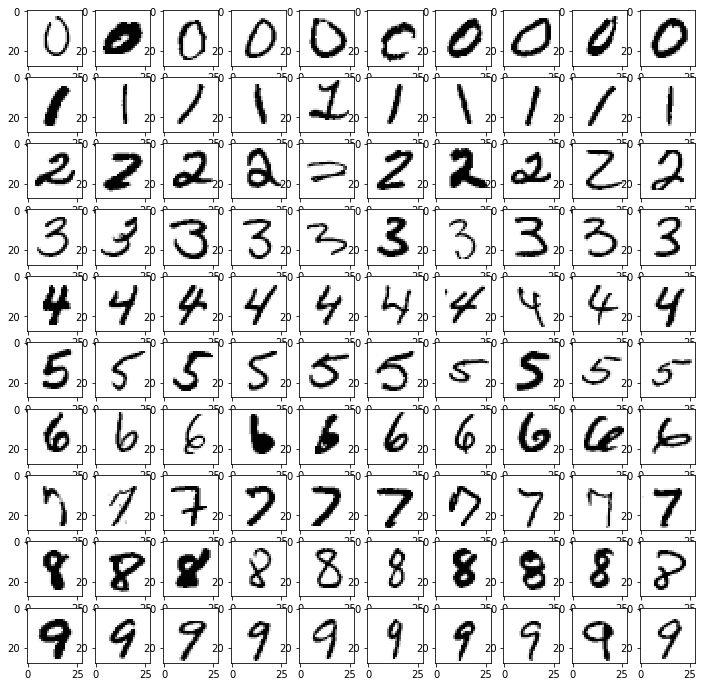

In [5]:
def P1(num_examples=10):
    
### STUDENT START ###  
    
    ## Set plot properties
    fig_size = 12
    fig = plt.figure()
    fig.set_figheight(fig_size)
    fig.set_figwidth(fig_size)
    plt.rc('lines', color='b')
    
    ## Initialize counter for position in the subplot grid
    plot_grid_count = 0
    
    ## Initialize matrix for caching pixel information for all examples of each image label
    example_images_for_label = np.zeros((num_examples,784))
    
    ## Iterate over all unique labels in the data set
    for label in np.unique(train_labels):
        x_for_label = train_data[train_labels == label]
        
        ## Shuffle the data set to randomly pick examples of the label images
        shuffle = np.random.permutation(np.arange(x_for_label.shape[0]))
        x_for_label = x_for_label[shuffle]
        example_images_for_label = x_for_label[:num_examples]
        
        ## Iterate over all example images and plot them on a grid for visualization
        for index in range(num_examples):
            plot_grid_count+=1
            pixels = np.array(example_images_for_label[index]*255, dtype='uint8')
            
            # Reshape the array into 28 x 28 array (2-dimensional array)
            pixels = pixels.reshape((28, 28))
            plt.subplot(num_examples,num_examples,plot_grid_count)
            plt.imshow(pixels, cmap='Greys')
            
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results


Classification report for k=1 (K-Nearest Neighbors with L2 Distance Metric)

              precision    recall  f1-score   support

     Digit=0       0.95      0.95      0.95       106
     Digit=1       0.89      0.98      0.93       118
     Digit=2       0.90      0.79      0.84       106
     Digit=3       0.93      0.87      0.90        97
     Digit=4       0.91      0.85      0.88        92
     Digit=5       0.86      0.88      0.87        88
     Digit=6       0.92      0.92      0.92       102
     Digit=7       0.85      0.94      0.89       102
     Digit=8       0.83      0.77      0.80        94
     Digit=9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000


Accuracies : [0.884 0.876 0.882 0.877 0.875]



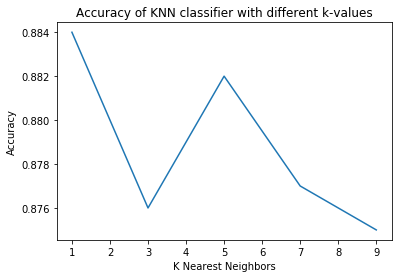

In [6]:
def P2(k_values):
    accuracyL2 = np.zeros(len(k_values))
### STUDENT START ###
    ## Iterate over all values of k and train kNN classifiers
    for iter_count, k in enumerate(k_values):
        kNNL2 = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto', metric = 'minkowski' )
        kNNL2.fit(mini_train_data, mini_train_labels)
        predictionsKNNL2 = kNNL2.predict(dev_data)
        
        # compute the number of correct predictions and divide by total to get accuracy
        correct = sum(predictionsKNNL2 == dev_labels)   
        accuracyL2[iter_count] = correct/len(dev_labels)
        
        ## Handle the k=1 case here for the required answer
        ## Create classification report for k=1
        if(k==1):
            print("\nClassification report for k=1 (K-Nearest Neighbors with L2 Distance Metric)\n")
            target_names = ['Digit=0', 'Digit=1', 'Digit=2', 'Digit=3', 'Digit=4', 'Digit=5', 'Digit=6','Digit=7','Digit=8','Digit=9']
            print(classification_report(dev_labels, predictionsKNNL2, target_names=target_names))
   
    print("\nAccuracies : {accuracy}\n".format(accuracy=accuracyL2))
    plt.plot(k_values,accuracyL2)
    plt.title('Accuracy of KNN classifier with different k-values')
    plt.xlabel('K Nearest Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

ANSWER: 

- The classifier has highest accuracy with *k*=1 with 88.4% correct labels. 
- The accuracy of the model decreases as the nearest neighbor count is increased 
- Based on the F1-score, number **8** is the most difficult digit.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

Training Data Set Size=100 | Execution Time=0.112secs| KNN Accuracy=0.70
Training Data Set Size=200 | Execution Time=0.303secs| KNN Accuracy=0.79
Training Data Set Size=400 | Execution Time=0.697secs| KNN Accuracy=0.81
Training Data Set Size=800 | Execution Time=1.559secs| KNN Accuracy=0.87
Training Data Set Size=1600 | Execution Time=3.359secs| KNN Accuracy=0.91
Training Data Set Size=3200 | Execution Time=6.564secs| KNN Accuracy=0.93
Training Data Set Size=6400 | Execution Time=13.482secs| KNN Accuracy=0.94
Training Data Set Size=12800 | Execution Time=27.797secs| KNN Accuracy=0.95
Training Data Set Size=25000 | Execution Time=56.709secs| KNN Accuracy=0.96


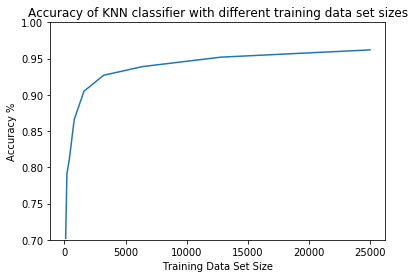

In [7]:
def P3(train_sizes, accuracies):
    
### STUDENT START ###
    ## Set k-Neighbors to 1
    k=1
    
    ## Initialize time counter and array of all time values
    start = time.time()
    times = []

    ## Iterate over all train data set sizes
    ## Re-train classifier for each size and compute prediction accuracy over dev data set.
    for iter_count, subset_size in enumerate(train_sizes):
        train_subset_data, train_subset_labels = train_data[:subset_size], train_labels[:subset_size]
        kNNL2_2 = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric = 'euclidean' )
        kNNL2_2.fit(train_subset_data, train_subset_labels)
        predictionsKNNL2_2 = kNNL2_2.predict(dev_data)
        accuracies = np.append(accuracies,np.mean(predictionsKNNL2_2 == dev_labels))
        times = np.append(times,time.time()-start)
        print("Training Data Set Size=%d | Execution Time=%.3fsecs| KNN Accuracy=%.2f" %(subset_size, times[iter_count], accuracies[iter_count]))
    return accuracies
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies  = []
accuracies  = P3(train_sizes, accuracies)

# Plot accuracy results of the kNN classifier with k=1
plt.plot(train_sizes,accuracies)
plt.title('Accuracy of KNN classifier with different training data set sizes')
plt.xlabel('Training Data Set Size')
plt.ylabel('Accuracy %')
plt.ylim(0.7,1)
plt.show()

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [8]:
def P4(trainSizes,accuracies):

### STUDENT START ###
    ## Train a linear regression model with non-zero intercept
    lr = LinearRegression(fit_intercept=True)
    regModel1 = lr.fit(trainSizes, accuracies)
    return regModel1

## Reshape the accuracies and train data sizes vectors to 2D for use with LinearRegression() function
accuracies2D = accuracies.reshape(-1,1)
trainSizes2D = np.array(train_sizes).reshape(-1,1)

### STUDENT END ###

regModel1 = P4(trainSizes2D,accuracies2D)

print("Adjusted R^2 Score = %.3f" % (regModel1.score(trainSizes2D,accuracies2D)))

trainSizeBig = [60000]
predictions = regModel1.predict(np.array(trainSizeBig).reshape(-1,1))
print("\nPredicted Accuracy for n = 60000 : %.3f" %(predictions))


Adjusted R^2 Score = 0.420

Predicted Accuracy for n = 60000 : 1.245


ANSWER:

Linear regression is predicting an accuracy of 1.245 for n = 60000. Since the support on accuracies is [0,1] this prediction is unsupported. As we see in the plot of accuracies in P5, the accuracies are highly skewed and not normally distributed. Thus linear regression is over-estimating the predicted accuracy.

In order to use linear regression we need to satify Gauss Markov assumptions that the training data is approximately normally distributed. This can be achieved by applying the logit transformation to the training data:
    
The logit tranformation is defined as: 
$$ \text{logit}(x) = \log \left(\frac{x}{1-x}\right) $$

and it bounds the output predictions between 0 & 1.

In [13]:
# Define logit transformation and inverse logit transformation
def logit(x): 
    return np.log(x/(1-x)) 

def inv_logit(x):
    return np.exp(x)/(np.exp(x)+1)

## Transform the accuracies data set using logit transform
accuracies_logit = logit(accuracies)
accuracies2D_logit = accuracies_logit.reshape(-1,1)

regModel2 = P4(trainSizes2D,accuracies2D_logit)
print("Adjusted R^2 Score = %.3f" % (regModel1.score(trainSizes2D,accuracies2D)))

predictions = regModel2.predict(np.array(trainSizeBig).reshape(-1,1))
predictions = inv_logit(predictions)
print("\nPredicted Accuracy for n = 60000 : %.3f" %(predictions))

Adjusted R^2 Score = 0.420

Predicted Accuracy for n = 60000 : 0.998


**The predicted accuracy is 99.8% after applying the logit transformation which is supported by the bounds of accuracies.**

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix


Confusion Matrix
 [[105   1   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 102   0   0   0   0   2   1   0]
 [  0   1   0  92   0   2   0   1   1   0]
 [  0   0   0   0  92   0   0   0   0   0]
 [  1   0   0   2   0  83   1   0   0   1]
 [  0   0   0   0   0   1 100   0   1   0]
 [  0   0   1   0   0   0   0 101   0   0]
 [  1   1   2   2   1   0   2   0  85   0]
 [  0   0   0   0   1   0   0   0   0  94]]

Display examples of most confused digits:



/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


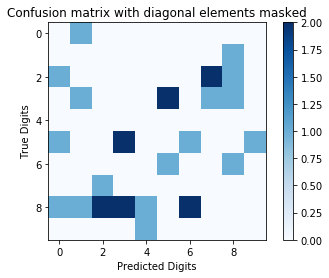

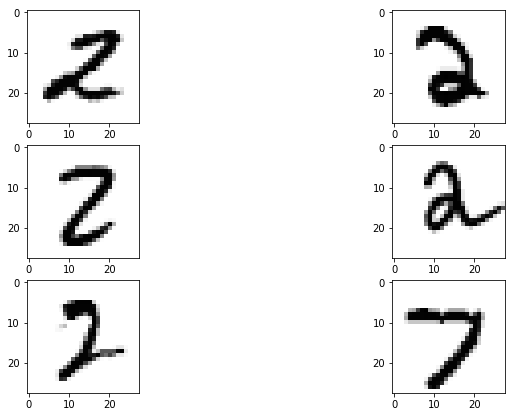

In [51]:
def P5():

### STUDENT START ###
    
    classes = np.unique(Y)  ## get the total number of classes = no of unique digits
    k=1 # set k = 1
    
    ## Train the classifier and predict on dev data set
    kNNL2_3 = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm='auto',metric='euclidean')
    kNNL2_3.fit(train_data, train_labels)
    predictionsKNNL2_3 = kNNL2_3.predict(dev_data)    
    
    ## Generate the confusion matrix
    cm = confusion_matrix(dev_labels,predictionsKNNL2_3)
    print("\nConfusion Matrix\n",cm)
    
    ## Create a mask of 1's along the diagnol
    ## This will be used to zero-out the diagnol elements that will aid in visualizing color map grid for non-diagnol elements
    mask = np.ones((len(classes),len(classes))) 
    mask = (mask - np.diag(np.ones(len(classes)))).astype(np.bool)
    cm_diag_masked = cm * mask
    indices = np.where(cm_diag_masked == cm_diag_masked.max())
    confused_true_label = indices[0][0]
    confused_predicted_label= indices[1][0]
    
    ## Plot the color heat map
    cmap = plt.cm.Blues
    fig1 = plt.figure(1)
    plt.imshow(cm_diag_masked,interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.xlabel("Predicted Digits")
    plt.ylabel("True Digits")
    plt.title("Confusion matrix with diagonal elements masked")
    plot_grid_count = 0
    
    ## Get the most confused digits from the non-diagonal elements of the confusion matrix
    confused_dev_indeces=np.where(dev_labels == str(confused_true_label))[0]
    confused_kNN_indeces=np.where(predictionsKNNL2_3 == str(confused_predicted_label))[0]
    
    
    print("\nDisplay examples of most confused digits:\n")
    fig_size = 12
    fig2 = plt.figure(2)
    fig2.set_figheight(fig_size)
    fig2.set_figwidth(fig_size)
    plt.rc('lines', color='b')
    plot_grid_count=0
    
    ## Plot examples of confused digits
    ## Arbitarily choose a slice of 35:40 rows from the dev data set for displaying confusion
    for index1, index2 in zip(confused_dev_indeces[35:40],confused_kNN_indeces[35:40]):
        plot_grid_count+=1
        pixels_of_true_label = np.array(dev_data[index1]*255, dtype='uint8')
        pixels_of_pred_label = np.array(dev_data[index2]*255, dtype='uint8')       
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        pixels_of_true_label = pixels_of_true_label.reshape((28, 28))
        pixels_of_pred_label = pixels_of_pred_label.reshape((28, 28))
        
        plt.subplot(5,2,plot_grid_count)
        plt.imshow(pixels_of_true_label, cmap='Greys')
        plt.subplot(5,2,plot_grid_count+1)
        plt.imshow(pixels_of_pred_label, cmap='Greys')
### STUDENT END ###
P5()


(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [ ]:
def P6():
    
### STUDENT START ###
   
    def gaussian_kernel(x,y,sigma):
        ## Gaussian probability density function (2-D)
        PI = 3.14159
        return 1/(2*PI*sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))

    def distance(r=1):
        ## Calculate linear distance from middle point
        return np.array(range(-r,r+1))

    def norm(data): 
        ## Normalize the sum to 1
        return data/np.sum(data)

    def smoothPixel(data,r_index,c_index,pcount,sigma):
        """
        data = a list or 1 dimensionsal vector containing the color intensities.
        r_index, c_index = row and column index of the pixel to smooth
        pcount = number of pixles to smooth 
        sigma = standard deviation of the Gaussian blurring kernel 
        """
        # Get the surrouding pixels for smoothing
        pixels = data[(r_index-pcount):(r_index+pcount+1),(c_index-pcount):(c_index+pcount+1)]
        # compute the distance from pixel
        distance1d = distance(1)
        # calculate 2d guassian density and normalize
        gaussian2d_norm = norm(gaussian_kernel(distance1d,distance1d,sigma))

        
        ## apply the gaussian kernel to the surrouding pixels and compute average
        return np.mean(pixels*gaussian2d_norm)
    
    ## Blur the image using gaussian filter
    def smoothImage(imgData,r,sigma):
        
        # iterate over all pixels in the image and ignore one row and column on the edge
        imgX = int(np.sqrt(len(imgData)))
        imgY = int(np.sqrt(len(imgData)))
        
        ## Reshape the image to 2D
        imgData = imgData.reshape(imgX,imgY)
        smoothedPixels = np.array([smoothPixel(imgData,row,col,r,sigma) for row in range(r,imgX-r) for col in range(r,imgY-r)])
        return smoothedPixels

    # Preprocess the training and dev data sets #
    
    # Preprocessing train data and dev data
    # sigma could be optimized for maximizing accuracy
    sigma = 0.33
    r = 1
    
    train_data_blurred = [smoothImage(example,r=r,sigma=sigma) for example in train_data]
    dev_data_blurred = [smoothImage(example,r=r,sigma=sigma) for example in dev_data]
    mini_train_data_blurred = [smoothImage(example,r=r,sigma=sigma) for example in mini_train_data]
    
    # Crop the dev and training data to match the size of smoothed images
    train_data_crop = [image.reshape(28,28)[1:27,1:27].ravel() for image in train_data]
    dev_data_crop = [img.reshape(28,28)[1:27,1:27].ravel() for img in dev_data]
    mini_train_data_crop = [image.reshape(28,28)[1:27,1:27].ravel() for image in mini_train_data]
    
    
    ## Fit KNN classifiers to smoothed data sets
    
    # Blur the images in training dataset
    kNNa = KNeighborsClassifier(n_neighbors=1)
    #kNNa.fit(train_data_blurred,train_labels)
    kNNa.fit(mini_train_data_blurred,mini_train_labels)
    predictions = kNNa.predict(dev_data_crop)
    print('Classification with blurred training images:\n',classification_report(dev_labels,predictions))

    # Blur the images in dev dataset
    kNNb = KNeighborsClassifier(n_neighbors=1)
    #kNNb.fit(train_data_cropped,train_labels)
    kNNb.fit(mini_train_data_crop,mini_train_labels)
    predictions= kNNb.predict(dev_data_blurred)
    print('Classification with blurred development images:\n',classification_report(dev_labels,predictions))


    # Blur the images in both training and dev data sets 
    kNNc = KNeighborsClassifier(n_neighbors=1)
    #kNNc.fit(train_data_blurred,train_labels)
    kNNc.fit(mini_train_data_blurred,mini_train_labels)
    pred_labels = kNNc.predict(dev_data_blurred)
    print('Both training data and dev data are preprocessed:\n',classification_report(dev_labels,pred_labels))
    
### STUDENT END ###

P6()

ANSWER:

**Blurring the train and dev data set increases the accuracy of the classifier but blurring only one of the train or dev data set images seems to decrease the accuracy of the classifier.**

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

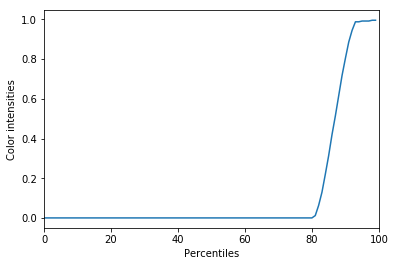

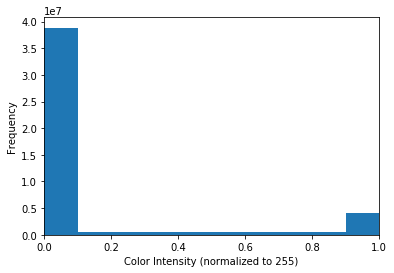

Naive Bayes classifier accuracy with binarized training data: 82.80%
Naive Bayes classifier accuracy with 3 categories of training data: 78.40%


In [52]:
# Define a function to binarize data
def binarize_pixels(data, threshold=0):
    binarized_data = np.zeros(data.shape)
    # Apply a threshold to each feature.
    binarized_data[:] = data[:] > threshold
    return binarized_data

## Define function to categorize data
def multiClass_pixels(data, thresholds=[0,0.9]):
    # Initialize a new feature array with the same shape as the original data.
    multiClass_data = np.zeros(data.shape)
    # Apply a threshold to each feature.
    multiClass_data[data >= thresholds[1]] = 2
    multiClass_data[(data >= thresholds[0])&(data<thresholds[1])] = 1
    multiClass_data[data < thresholds[0]] = 0
    return multiClass_data

## Function for Bernoulli NB classifier
def P7(alpha=1):
    clfBerNB = BernoulliNB(alpha=alpha, fit_prior=False)
    clfBerNB.fit(binarized_train_data, train_labels)
    clfBerNBscore = 100 *  clfBerNB.score(binarized_dev_data, dev_labels)
    pred_labels = clfBerNB.predict(binarized_dev_data)
    print('Naive Bayes classifier accuracy with binarized training data: %.2f%%' %clfBerNBscore)

## Function for Multinomial NB classifier
def P7a(alpha=1):
### STUDENT START ##
    clfMultiNB = MultinomialNB(alpha=alpha, fit_prior=False)
    clfMultiNB.fit(multiClass_train_data, train_labels)
    clfMultiNBscore = 100 *  clfMultiNB.score(multiClass_dev_data, dev_labels)
    print('Naive Bayes classifier accuracy with 3 categories of training data: %.2f%%' %clfMultiNBscore)

## plot the data to help decide on the thresholds
flattened_train_data = train_data.flatten()
# plot percentiles to help choosing
plt.plot(np.percentile(flattened_train_data,range(0,100,1)))
plt.ylabel('Color intensities')
plt.xlabel('Percentiles')
plt.xlim(0,100)
plt.show()

# Flatten the data set and plot a histogram to visualize the distribution of the data 
plt.hist(flattened_train_data,bins=10,histtype='bar')
plt.ylabel('Frequency')
plt.xlabel('Color Intensity (normalized to 255)')
plt.xlim(0,1.0)
plt.show()
    
# Create new binarized training and test data
binarized_train_data = binarize_pixels(train_data, threshold=0)
binarized_dev_data = binarize_pixels(dev_data, threshold=0)
   
# Create categorized data with three classes    
multiClass_train_data = multiClass_pixels(train_data,thresholds=[0,0.9])
multiClass_dev_data = multiClass_pixels(dev_data,thresholds=[0,0.9])

# Set smoothing parameter
alpha=1

P7(alpha)
P7a(alpha)

ANSWER:
    
The multinomial Naive Bayes classifier is no better than the Bernoulli NB classifier for our dataset. The histogram of the pixel intensity data set shows a bimodal distribution with peaks at the low and high ends and no significant values in between. This distribution explains why the multinomial NB classifier doesn't perform better than the binomial classifier since there are not enough  data in the middle class for training the multinomial classifier. This could be the case if the hand written digits were written in black & white ink. If there were handwritten digits with colored ink, then we may have more pixel intensities in the middle category for the multinomial NB classifier to train better.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

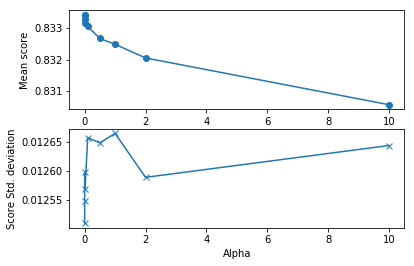


 Results with alpha = 0

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       106
           1       0.90      0.96      0.93       118
           2       0.84      0.76      0.80       106
           3       0.72      0.76      0.74        97
           4       0.77      0.84      0.80        92
           5       0.86      0.67      0.75        88
           6       0.88      0.91      0.89       102
           7       0.95      0.86      0.90       102
           8       0.73      0.72      0.73        94
           9       0.75      0.83      0.79        95

   micro avg       0.83      0.83      0.83      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.83      0.83      1000


Log probabilties of features:
 [[-31.71447324 -31.71447324 -31.71447324 ... -31.71447324 -31.71447324
  -31.71447324]
 [-31.8443332  -31.8443332  -31.8443332  ... -31.8443332  -31.8443332
  -31.8443332 ]
 [-31.7251

/usr/local/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [53]:
def P8(alphas):

### STUDENT START ###

    # --------------------- Use GridSeardCV to optimize alpha, fit and cross validate ---------------- #
    bernoulli0 = BernoulliNB(binarize=0)
    bernoulli0_cv = GridSearchCV(bernoulli0,alphas, cv=100)
    optim_fit = bernoulli0_cv.fit(train_data, train_labels)
    return optim_fit

## Changed alpha= 0 to alpha=1e-6 to avoid generating warnings for alpha too small
alphas = {'alpha': [1e-6, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb=P8(alphas)

std_scores  = nb.cv_results_['std_test_score']
mean_scores = nb.cv_results_['mean_test_score']

plt.subplot(2,1,1)
plt.plot(alphas['alpha'], mean_scores,'-o')
plt.ylabel('Mean score')
plt.subplot(2,1,2)
plt.plot(alphas['alpha'], std_scores,'-x')
plt.ylabel('Score Std. deviation')
plt.xlabel('Alpha')
plt.show()   

bernoulli0_zeroalpha = BernoulliNB(alpha=0, binarize=0)
nb_zeroalpha = bernoulli0_zeroalpha.fit(train_data, train_labels)
nb_zeroalpha_preds = nb_zeroalpha.predict(dev_data)
print("\n Results with alpha = 0\n")
print(classification_report(dev_labels,nb_zeroalpha_preds))

print('\nLog probabilties of features:\n', bernoulli0_zeroalpha.feature_log_prob_)
    
### STUDENT END ###

In [46]:
print(nb.best_params_)

{'alpha': 0.001}


ANSWER:

- The best value is $\alpha$ = **0.001**. 
- The accuracy is close with alpha = 0 which is expected since going smaller than $\alpha$ = **0.001** doesn't give us any significant improvements due to computational constraints of the classifier.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Gaussian Naive Bayes Classification Report
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       106
           1       0.83      0.92      0.88       118
           2       0.89      0.23      0.36       106
           3       0.73      0.38      0.50        97
           4       0.93      0.28      0.43        92
           5       0.79      0.12      0.22        88
           6       0.61      0.92      0.73       102
           7       0.91      0.40      0.56       102
           8       0.27      0.60      0.37        94
           9       0.42      0.96      0.58        95

   micro avg       0.59      0.59      0.59      1000
   macro avg       0.72      0.57      0.55      1000
weighted avg       0.72      0.59      0.56      1000

theta:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 sigma:
[[1.99408716e-10 1.994087

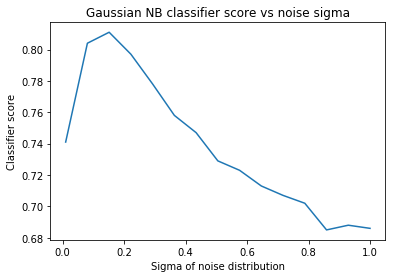

In [247]:
def P9():

### STUDENT START ###
    ## Since we are using guassian NB classifier there is no need to binarize the training data
    gaussian_model = GaussianNB()
    gaussian_model.fit(train_data, train_labels)
    predictions = gaussian_model.predict(dev_data)
    print('Gaussian Naive Bayes Classification Report\n',classification_report(dev_labels,predictions))
    print('theta:\n{theta}\n\n sigma:\n{sigma}\n'.format(theta=gaussian_model.theta_,sigma=gaussian_model.sigma_))
    
    
    ## Add random noise to the data to create a normally distrubted training set 
    ## mean = 0, sigma = 0.01
    rand_noise = []
    mu = 0
    sigma = 0.1
    for i in range(len(train_data)):
        ## draw samples from a random distribution and append
        rand_noise.append(np.random.normal(mu,sigma,train_data.shape[1])) 
    train_data_with_noise = train_data+rand_noise  ## add noise to data

    ## Define a gaussian NB classifier to fit with noisy data
    gaussian_random = GaussianNB()
    gaussian_random.fit(train_data_with_noise, train_labels)
    predictions_with_noise = gaussian_random.predict(dev_data)
    print('Gaussian Naive Bayes classification report with random noise added to training data \n', classification_report(dev_labels,predictions_with_noise))
    
    ## Plot the classifier score vs sigma of random noise added to training data set
    rand_noise2 = np.zeros(train_data.shape)
    score_with_noise = []
    sigmas = np.linspace(0.01,1,15)
    for sigma in sigmas:
        for i in range(len(train_data)):
            rand_noise2[i] = np.random.normal(mu,sigma,train_data.shape[1])
        train_data_with_noise = train_data+rand_noise2
        gaussian_random = GaussianNB()
        gaussian_random.fit(train_data_with_noise, train_labels)
        score_with_noise.append(gaussian_random.score(dev_data,dev_labels))
    plt.plot(sigmas,score_with_noise)
    plt.xlabel('Sigma of noise distribution')
    plt.ylabel('Classifier score')
    plt.title('Gaussian NB classifier score vs noise sigma')
    plt.show()
        
### STUDENT END ###

gnb = P9()

ANSWER:


- The accuracy of the gaussian NB classifier is much lower (59%) compared to Naive NB classifier (82%). This is due to the fact that all the model coefficients and standard deviations are computed to be zero in the model above. Since gaussian model assumed normally distributed data and our training data has a large number of zero intensities, the guassian model parameters compute to zero. 
- In order to fix our gaussian NB accureacy we can add normally distributed random noise to the training data. This is done in the above code cell and the returned accuracy is very close to the bernoulli NB classifier after random noise is added.
- The standard deviation of added noise distribution also impacts the accurancy of the gaussian NB classifier. The optimal accuracy of the gaussian NB clasifier is achieved at sigma = 0.1

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

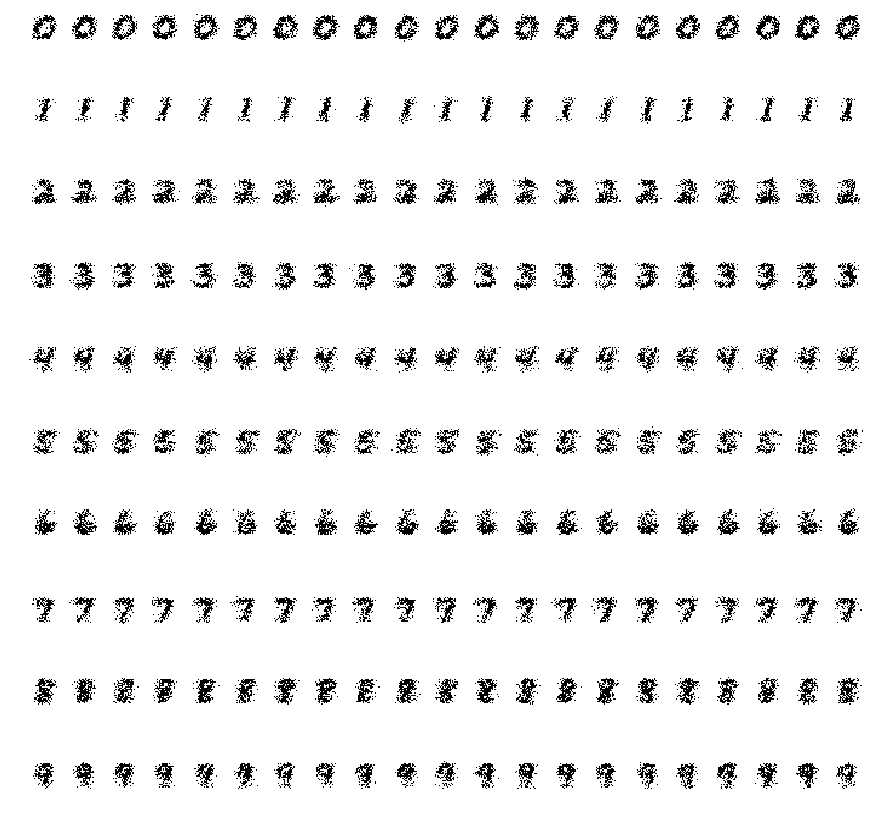

In [410]:
def P10(num_examples):

### STUDENT START ###
    # fit model
    bernoulli = BernoulliNB(alpha=1e-6,binarize=0)
    bernoulli.fit(train_data, train_labels)
    
    ## Set image and pixel grid
    imageX = int(np.sqrt(train_data.shape[1]))
    imageY = int(np.sqrt(train_data.shape[1]))

    # Inititalize figure and axes
    figSize = 15
    fig, ax = plt.subplots(nrows=10, ncols=num_examples+1, figsize=(figSize,figSize))

    ## generate each digit, num_examples times
    # generate subplot for each example for each digit
    for digit in range(10):
        for example in range(num_examples+1):
            
            # get probability of each pixel for a digit from the fitted model
            fitted_pixel_prob_for_digit = np.exp(bernoulli.feature_log_prob_)[digit]
            
            ## generate a random array of pixels with length equal to feature length
            random_pixels = np.random.rand(train_data.shape[1])
            
            ## Compare pixel probability in 28x28 grid to randon numbers. Since digits are written with black ink
            ## the pixels with feature probability higher than random numbers will represent whitespace and lower 
            ## probability will represent part of the digit
            generated_pixels = fitted_pixel_prob_for_digit > random_pixels
            generated_image = generated_pixels.reshape(imageX, imageY)
            
            ## show the generate digit image
            ax[digit][example].imshow(generated_image,cmap='Greys')
            
    [axis.set_axis_off() for axis in ax.ravel()]
    plt.show()
    
### STUDENT END ###

P10(20)

ANSWER:

- The generated digits from the bernoulli NB model is much more noisy compared to the digits in the training set. This is due to the approximation in the bernoulli NB classifier model.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?


Accuracy of classifier for each posterior bucket:

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  30    accuracy = 0.367
p(pred) <= 0.9990000000000    total = 124    accuracy = 0.403
p(pred) <= 0.9999900000000    total = 198    accuracy = 0.485
p(pred) <= 0.9999999000000    total = 263    accuracy = 0.559
p(pred) <= 0.9999999990000    total = 332    accuracy = 0.602
p(pred) <= 0.9999999999900    total = 407    accuracy = 0.644
p(pred) <= 0.9999999999999    total = 477    accuracy = 0.686
p(pred) <= 1.0000000000000    total = 500    accuracy = 0.696


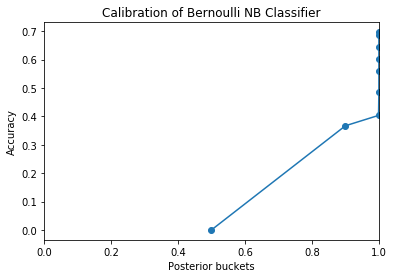

In [492]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    
    ## Set reasonable value of alpha
    alpha = 0.5

    # fit model
    bernoulli = BernoulliNB(alpha=alpha)
    bernoulli.fit(binarized_train_data, train_labels)
    posterior_probs = bernoulli.predict_proba(dev_data)

    ## iterate over all rows of the posterior probability matrix and get the maximum value and the digit label for the max value
    posterior_max,pred_labels =zip(*map(lambda posterior_prob: (posterior_prob.max(), posterior_prob.argmax()),posterior_probs))  
    ## Put the posterior probabilties in bucket bins
    bin_indeces_of_posterior = np.digitize(posterior_max,buckets)
    # count totals of each bin
    total = np.bincount(bin_indeces_of_posterior)

    ## Find all the correct predictions 
    ## Need to convert true labels from string type to integer for logical comparison
    correct_preds = (pred_labels == np.int64(dev_labels))
    
    ## Now find the correct predictions in each bucket
    correct = map(lambda bin_num: sum(correct_preds[np.where(bin_num==bin_indeces_of_posterior)]), np.arange(np.max(bin_indeces_of_posterior)+1))
                                   
    # update correct and total variables
    correct,total = np.add.accumulate(list(correct)),np.add.accumulate(total)
    return (buckets,correct.astype(float),total)
    
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

result = P11(buckets,correct,total)
buckets,correct,total = result

accuracy = np.zeros((len(buckets)))

print("\nAccuracy of classifier for each posterior bucket:\n")
for i in range(len(buckets)):
    accuracy[i] = 0.0
    if (total[i] > 0): accuracy[i] = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy[i]))
    
# Plot the accuracy versus buckets (calibration visualization)
fig, axes = plt.subplots()    
axes.plot(buckets,accuracy,'o-')
axes.set_xlabel('Posterior buckets')
axes.set_xlim([0,1])
axes.set_ylabel('Accuracy')
plt.title('Calibration of Bernoulli NB Classifier')
plt.show()
    

ANSWER:

- The classifier accuracy is far less than 90% when the posterior probabilitiy of predicted class is 0.9
- The classifier has higher accuracy when posterior probability is higher than when is is lower. The classifier has a positive correlation of accuracy with posterior probability. Thus we will characterize this classifier as "weakly calibrated". 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [ ]:
def P12():

### STUDENT START ###

    ## compute averages of pixel intensities for the rows and column
    def pixel_sum(image):
        image2D = image.reshape((28,28))  # reshape flat arraty in to 2D image array
        row_sums = np.sum(image2D, axis=0)
        col_sums = np.sum(image2D, axis=1)
        return np.append(row_sums,col_sums)
    
    ## loop over all rows in the train data set and add new features
    train_data_new_features = np.zeros((60000,840))
    for index, example in enumerate(train_data):
        train_data_new_features[index] = np.append(train_data[index], pixel_sum(example))
    
    ## Train and predict using a gaussing NB classifier with the addtional features
    gaussianNB1 = GaussianNB()
    gaussianNB1.fit(train_data_new_features, train_labels)
    predictions = gaussianNB1.predict(dev_data)
    score = gaussianNB1(predictions, dev_labels)
    
    ## display the classification report
    print(\n"Classification report of gaussian NB with additional features:\n", classification_report(dev_labels, predictions))
    
    
### STUDENT END ###
P12()